# First break picking using semantic segmentation approach 

In this notebook, we will continue to discuss first break picking task, but now we will try to treat this task as semantic segmentation. In this case, the neural network predicts a binary mask where each sample of a trace before the first break is labeled as the no-signal one while all the samples after the first break — as signal ones.

* [Dataset](#Dataset)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

In [1]:
%env CUDA_VISIBLE_DEVICES=3
%load_ext autoreload

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import sys
sys.path.append('../../../')

import numpy as np
import matplotlib.pyplot as plt

from SeismicPro.seismicpro.src import SeismicDataset, Survey, MetricMap
from SeismicPro.seismicpro.src.gather import FirstBreaksOutliers
from SeismicPro.seismicpro.src.metrics import PipelineMetric, pass_coords, pass_batch, pass_calc_args
from SeismicPro.seismicpro.batchflow import B, V, F, L, Pipeline
from SeismicPro.seismicpro.src.gather.utils import convert_mask_to_pick
from batchflow.models.torch import TorchModel
from SeismicPro.seismicpro.batchflow.models.torch import UNet, ResBlock

import warnings
warnings.filterwarnings("ignore")

In [44]:
sgy_path = '../processing_/data/test_g_coord.sgy'
picking_path = "../processing_/data/VAY22_picking"
save_breaks_path = "../processing_/data/VAY22_predicted_breaks_1d"
breaks_2d_path = '../processing_/data/picking_v3_max'
save_model_path = '../processing_/data/1d_unet'

BATCH_SIZE = 512
N_EPOCHS = 15

In [4]:
def plot_loss(loss):
    plt.figure(figsize=(25, 6))
    plt.grid()
    plt.plot(loss)
    plt.title('Loss history during training', fontsize=16)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('BDice Loss', fontsize=16)
    plt.show()

Define all necessery imports

## Dataset

Initialize surveys and load first breaks

In [5]:
header_cols = ['TraceNumber', "INLINE_3D", "CROSSLINE_3D", "offset", "SourceX", "SourceY", "GroupX", "GroupY", "CDP_X", "CDP_Y"]
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=header_cols, name='raw')

survey.load_first_breaks(picking_path, inplace=True, first_breaks_col='FirstBreak')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [6]:
dataset = SeismicDataset(survey)
dataset.split(shuffle=True)

In [7]:
dataset = dataset.reindex('TRACE_SEQUENCE_FILE')

In [8]:
dataset.test.size, dataset.train.size

(16890, 66677)

## Model Architecture
Specify model config, optimizer and loss function. We use UNet-based architecture consisting of two parts - encoder and decoder. Both of them are based on ResNet-like models with Concurrent Spatial and Channel Squeeze & Excitation attention blocks.

In [ ]:
basic_unet_config = {
    'inputs_shapes': (1, 800),
    
    'order': ['encoder', 'embedding', 'decoder', 'head'],
    

    'encoder': { 'type': 'encoder',
                 'order': ['block', 'skip', 'downsample'],
                 'num_stages': 4,
                 'blocks': { 'layout': 'cna cna',
                             'kernel_size': 5,
                             'padding': 'same',
                             'stride': 1,
                             'channels': [8, 16, 32, 64],
                             'bias': False
                            },
                'downsample': {'layout': 'p',
                               'kernel_size': 2,
                               'stride': 2,
                               'channels': 'same * 2'
                              } 
               },
    'embedding': {
                'input_type': 'list',
                'input_idx': -1,
                'output_type': 'list',
                'layout': 'cna cna',
                'kernel_size': 3,
                'padding': 'same',
                'channels': 128,
            },
    
    'decoder': {
        'skip': True,
        'indices':  [3, 2, 1, 0],
        'type': 'decoder',
        'num_stages': 4,
        'order': ['upsample', 'combine', 'block'],
        'blocks': {'layout': 'cna cna', 
                   'channels': [64, 32, 16, 8],
                   'kernel_size': 5, 
                   'stride': 1,
                   'padding': 'same',
                   'bias': False
                  },
        'combine': {'op': 'concat', 'force_resize': False}, 
        'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True} # kernel_size = 3 (checkboards)
    },
    'head': {
        'layout': 'c', 'channels': 1,
        'classes': 2
    },
    
    'loss': 'bdice', 
    'device': 'gpu:0',
    'optimizer': {'name': 'Adam', 'lr': 1e-3},
    'output': 'sigmoid',
    'model_class': TorchModel
}

batchflow_model = TorchModel(basic_unet_config)
batchflow_model.repr(2)

In [19]:
def get_unet_resblock_config(n_layers, crop_shape=(1, 800), scale_factor=1):
    block_channels = [
                        [16, 16, 64], 
                        [16, 16, 128],
                        [32, 32, 256],
                        [64, 64, 512]]
    
    branch_channels = [64, 128, 256, 512]
    if scale_factor != 1:
        branch_channels = [(channels // scale_factor) for channels in branch_channels]
        block_channels = (np.array(block_channels) // scale_factor).tolist()
        
    autoencoder_res_unet_n_config = {
        'inputs_shapes': crop_shape,

        'order': ['encoder', 'embedding', 'decoder', 'head'],


        'encoder': { 'type': 'encoder',
                     'order': ['block', 'skip'],
                     'num_stages': n_layers,
                     'blocks': { 'layout': 'Rcna cna cnS+a',
                                 'kernel_size': [1, 3, 1],
                                 'padding': [0, 1, 0],
                                 'stride': [2, 1, 1],
                                 'channels': block_channels[:n_layers], # HW: (400, 200, 100, 50)
                                 'bias': False,
                                 'attention': 'se',

                                 'branch': {'layout': 'vcn',  
                                            'pool_size': 2,
                                            'pool_stride': 2,
                                            'kernel_size': 1,
                                            'stride': 1,
                                            'padding': 0,
                                            'channels': branch_channels[:n_layers],
                                            'bias': False
                                            },
                                },
                    'output_type': 'list'
                   },
        'embedding': {
                    'input_type': 'list',
                    'input_idx': 3,
                    'output_type': 'list',
                    'layout': 'Rcna cna cnS+a',
                    'kernel_size': 3,
                    'padding': 'same',
                    'channels': branch_channels[n_layers - 1] * 2,
                    'bias': False,
                    'attention': 'se',

                    'branch': {'layout': 'cn', 
                               'kernel_size': 1,
                               'padding': 'same',
                               'stride': 1,
                               'channels': branch_channels[n_layers - 1] * 2, # C: (64, 128, 256, 1024)
                               'bias': False
                              },
                      },

        'decoder': {
            'skip': True,
            'input_type': 'list',
            'indices': [3, 2, 1, 0],
            'type': 'decoder',
            'num_stages': n_layers,
            'order': ['block', 'combine', 'upsample'],
            'blocks': {'layout': 'Rcna cna cnS+a', 
                       'channels':  branch_channels[n_layers - 1::-1] , 
                       'kernel_size': 3, 
                       'stride': 1,
                       'padding': 'same',
                       'bias': False,
                       'attention': 'se',
                       
                       'branch': {'layout': 'cn',  
                                            'kernel_size': 1,
                                            'stride': 1,
                                            'padding': 0,
                                            'channels': branch_channels[n_layers - 1::-1],
                                            'bias': False
                                            },
                      },
            'combine': {'op': 'concat', 'force_resize': False, },

            'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True}
        },
        'head': {
            'layout': 'c', 'channels': 1, 'kernel_size': 1, 'stride': 1, 'padding': 0, 'bias': True
        },

        'loss': 'bdice', 
        'model_class': TorchModel,
        'output': 'sigmoid',
        'optimizer': {'name': 'Adam', 'lr': 1e-3},
        'device': 'gpu:0',

    }
    return autoencoder_res_unet_n_config

In [6]:
batchflow_model = TorchModel(get_unet_resblock_config(n_layers=4, scale_factor=8))
batchflow_model.repr(2)

Network(
    (encoder): EncoderModule(
        (block-0:  (?,   1, 800)  ⟶ (?,   8, 400))
        (skip-0:   (?,   8, 400)  ⟶ (?,   8, 400))
        (block-1:  (?,   8, 400)  ⟶ (?,  16, 200))
        (skip-1:   (?,  16, 200)  ⟶ (?,  16, 200))
        (block-2:  (?,  16, 200)  ⟶ (?,  32, 100))
        (skip-2:   (?,  32, 100)  ⟶ (?,  32, 100))
        (block-3:  (?,  32, 100)  ⟶ (?,  64,  50))
        (skip-3:   (?,  64,  50)  ⟶ (?,  64,  50))
    )
    (embedding: [(?,   8, 400),
                 (?,  16, 200),
                 (?,  32, 100),
                 (?,  64,  50),
                 (?,  64,  50)] ⟶ [(?,   8, 400),
                                    (?,  16, 200),
                                    (?,  32, 100),
                                    (?,  64,  50),
                                    (?,  64,  50),
                                    (?, 128,  50)])
    (decoder): DecoderModule(
        (block-0:     (?, 128,  50)  ⟶ (?,  64,  50))
        (combine-0:  [(?,  64

## Training
Define training pipeline that contains all procedures from data loading to model training. This pipeline runs for 5 epochs.

In [20]:
model_config = get_unet_resblock_config(n_layers=4, scale_factor=8)

train_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .init_variable('loss_history', [])
    .init_model('fbp_model', config=model_config)
    .init_variable('predicted_times')
    .init_variable('mae', [])
        
    # data preprocessing
    .load(src='raw', combined=True, limits=800)
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)

    # mask preprocessing
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak')
    .make_model_inputs(src=L('raw').data, dst='prepared_mask', expand_dims_axis=1)
    
    # prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    # result prostprocessing
    .convert_mask_to_pick(mask=L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times', mode='w'))
                  
    # collecting metric
    .mean(abs(V('predicted_times') - B('raw')[0]['FirstBreak'].squeeze()), save_to=V('mae', mode='a'))
                  
    # model training and loss accumulating
    .train_model('fbp_model', outputs='loss', inputs=L('inputs'),
                 targets=L('prepared_mask'), save_to=V('loss_history', mode='a'))
    )

train_pipeline = train_template << dataset.train
train_pipeline.run(5000, n_epochs=10, drop_last=True, shuffle=True, bar='n')

  0%|                                                                                                         …

In [25]:
train_pipeline.save_model_now(name='fbp_model', path=save_model_path)

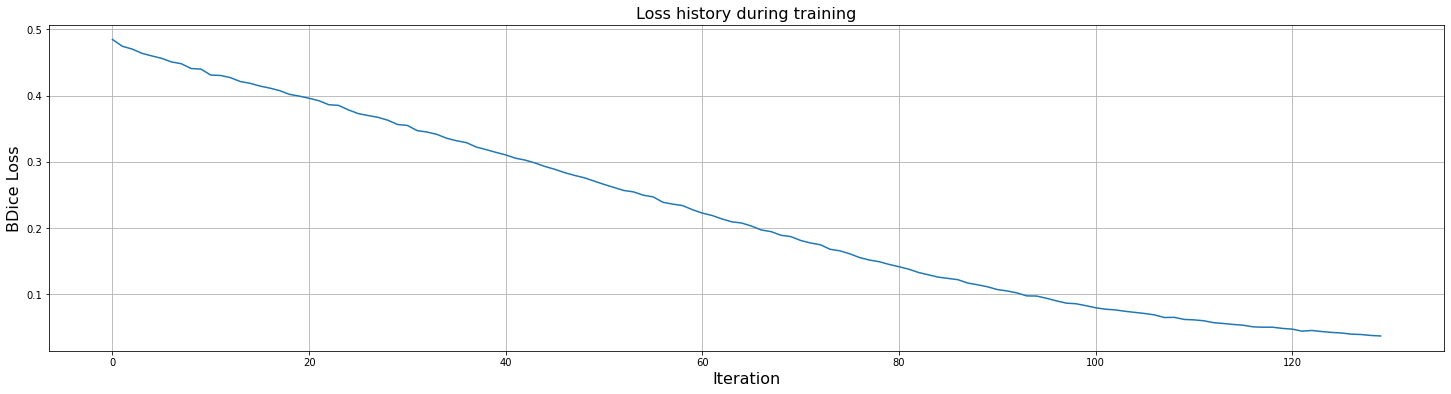

In [21]:
plot_loss(train_pipeline.v('loss_history'))

In [79]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # no scale

Mean absolute error is 11.14 samples


In [117]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 2, kernel 3

Mean absolute error is 17.63 samples


In [123]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 2, kernel 5

Mean absolute error is 22.05 samples


In [127]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 1, kernel 5

Mean absolute error is 14.29 samples


In [136]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 1, kernel 3, attention se

Mean absolute error is 11.14 samples


In [84]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 5 epochs, lr 9e-4

Mean absolute error is 4.43 samples


In [94]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 5 epochs, lr 9e-4

Mean absolute error is 7.89 samples


In [102]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 5 epochs, lr 3e-4

Mean absolute error is 9.23 samples


In [102]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 5 epochs, lr 1e-4

Mean absolute error is 9.23 samples


In [111]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 5 epochs, lr 2e-4

Mean absolute error is 7.21 samples


In [116]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 7 epochs, lr 2e-4

Mean absolute error is 5.19 samples


In [18]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 10 epochs, lr 5e-2, bs 10000

Mean absolute error is 26.48 samples


In [22]:
print(f"Mean absolute error is {train_pipeline.v('mae')[-1]:.2f} samples") # scale 8, kernel 3, attention se, 10 epochs, lr 1e-3, bs 5000

Mean absolute error is 9.12 samples


## Inference

Measure model's quality as a module of the distance between predicted and real times of first break. To convert binary mask to picking we use ```mask_to_pick``` method that defines the first break as the beginning of the longest sequence of signal samples in a mask.

In [23]:
val_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .import_model('fbp_model', source=train_pipeline)
    .init_variable('predicted_times')
    .init_variable('mae', [])
    
    # loading and data preparation
    .load(src='raw', combined=True, limits=800)
                
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)
    # model prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    
    # result prostprocessing
    .convert_mask_to_pick(L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times', mode='w'))
    .mean(abs(V('predicted_times') - B('raw')[0]['FirstBreak'].squeeze()), save_to=V('mae', mode='a'))
)

val_pipeline = val_template << dataset.test
val_pipeline.run(BATCH_SIZE, n_iters=1000, drop_last=True, shuffle=False, bar='n')

  0%|                                                                                                         …

In [ ]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # no se

In [139]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # se

Mean absolute error is 10.86 samples


In [98]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 5 epochs lr 9e-4

Mean absolute error is 27.76 samples


In [91]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 3 epochs lr 9e-4

Mean absolute error is 15.39 samples


In [104]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 3 epochs lr 3e-4

Mean absolute error is 19.01 samples


In [113]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 3 epochs lr 2e-4

Mean absolute error is 20.40 samples


In [118]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 7 epochs lr 2e-4

Mean absolute error is 16.84 samples


In [24]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") # scale 8 se 10 epochs lr 1e-3 bs 5000

Mean absolute error is 7.63 samples


## Model evaluation
Let's visualize the predictions of the model. Firstly, reindex the dataset by FieldRecord, in order to make predictions for gathers, not for traces.

In [26]:
dataset_inference = dataset.test.copy()

In [27]:
dataset_inference.index.reindex('FieldRecord', inplace=True)

In [28]:
def save_predicted_breaks(survey, times, predicted_breaks_col="PredictedBreak"):
    for i, fb in enumerate(times):
        survey[i][predicted_breaks_col] = fb

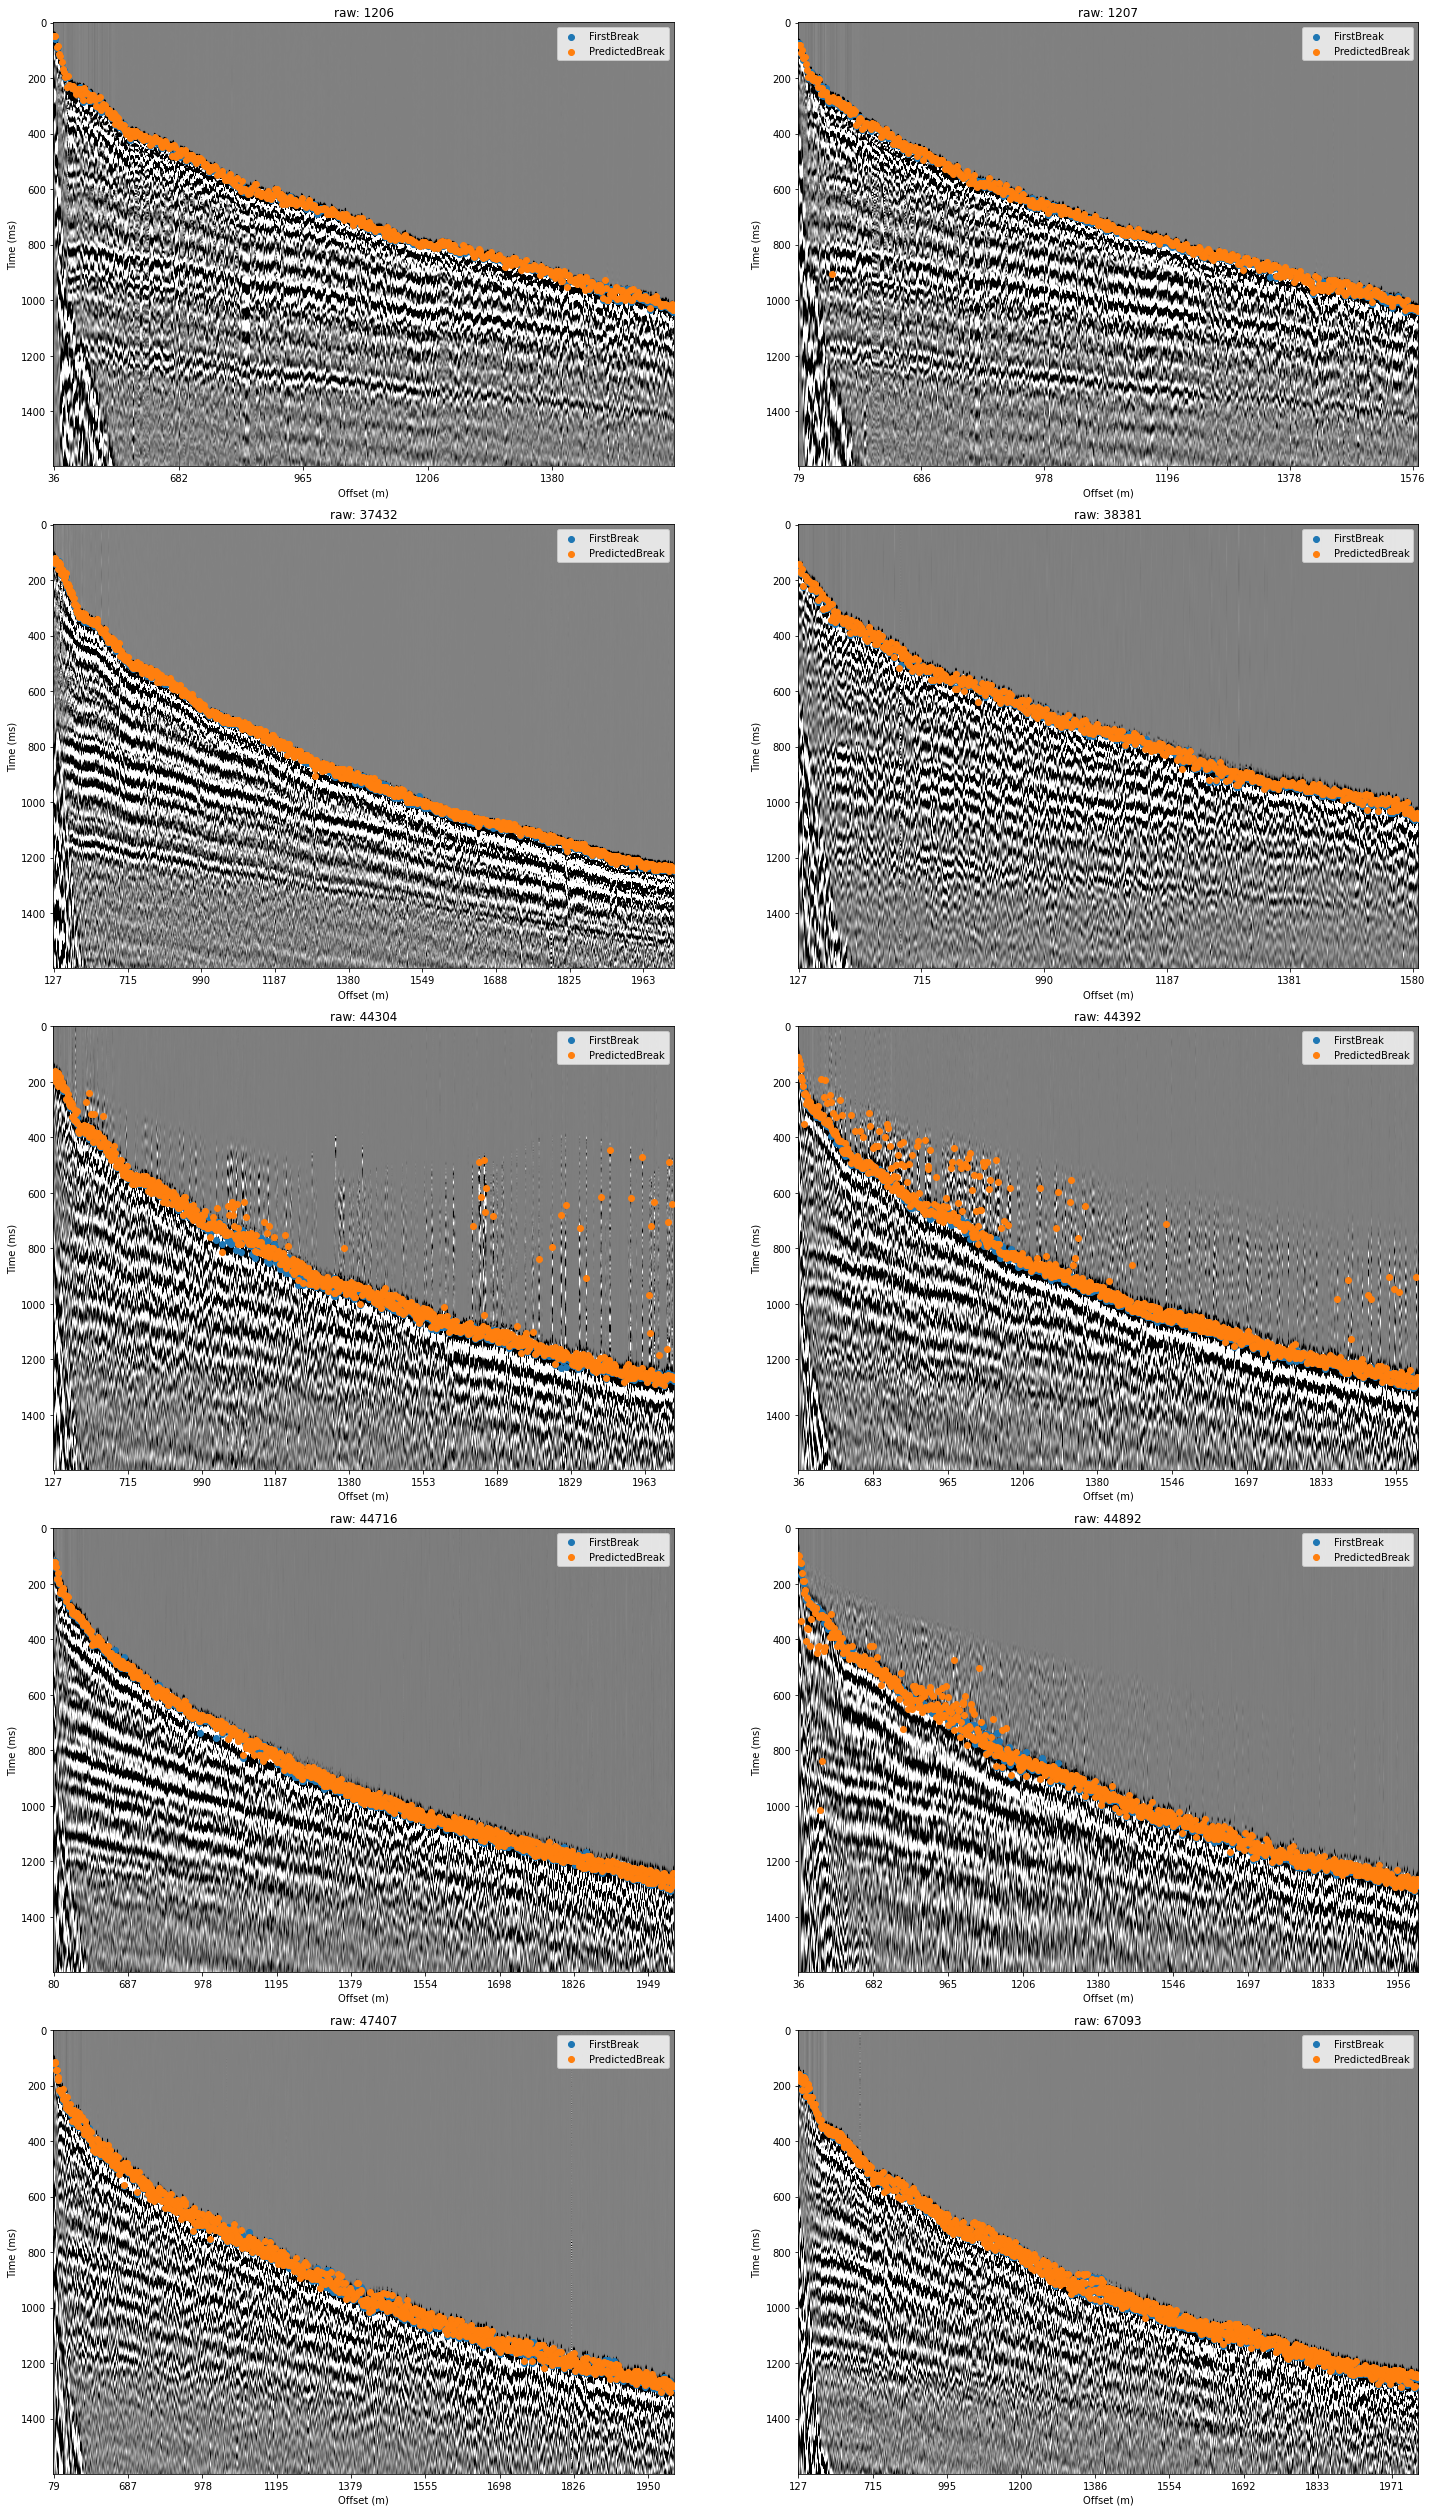

In [31]:
plot_pipeline_template = (Pipeline()
    .import_model('fbp_model', train_pipeline)
    .init_variable('predicted_times')
    .init_variable('PredictedBreak')
                          
    # loading and data preparation
    .load(src='raw', limits=800)
    .scale_standard(src='raw')
    .make_model_inputs(src=L('raw').data, dst='inputs', expand_dims_axis=1)
                          
    .predict_model('fbp_model', inputs=B('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))

    # result prostprocessing
    .convert_mask_to_pick(mask=L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times'))
    .split_model_outputs(src=V('predicted_times'), dst=V('PredictedBreak'), shapes=L('raw').shape[0])
    .save_predicted_breaks(survey=L('raw'), times=V('PredictedBreak'))
    .sort(src='raw', by='offset')
    .plot(src='raw', event_headers=['FirstBreak', 'PredictedBreak'])
    )

# plot_pipeline = plot_pipeline_template << dataset_inference
batch = plot_pipeline.next_batch(batch_size=10)

## Save Predictions

In [32]:
header_cols = ['TraceNumber', 'FieldRecord',  "offset"]
survey = Survey(sgy_path, header_index='TRACE_SEQUENCE_FILE', header_cols=header_cols, name='full')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [33]:
len(survey.headers.index.unique())

58706100

In [10]:
# survey.reindex('FieldRecord', inplace=True)

In [57]:
survey_small = survey.copy()

indices = np.random.choice(survey.headers.index.unique(), size=138)

survey_small.headers = survey.headers[survey.headers.index.isin(indices)]

In [34]:
dataset = SeismicDataset(survey)

In [35]:
len(dataset)

58706100

In [39]:
dataset.reindex('TRACE_SEQUENCE_FILE', inplace=True)

In [46]:
save_pipeline_template = (Pipeline()
                          .load_model('fbp_model', path=save_model_path, model_class=TorchModel)
                          .init_variable('predicted_times')
                          .init_variable('PredictedBreak')
                          
                          .load(src='full', combined=True, limits=800)
                          
                          .scale_standard(src='full')
                          .make_model_inputs(src=L('full').data, dst='inputs', expand_dims_axis=1)
                          
                          # .predict_model('fbp_model', inputs=B('inputs'), outputs='sigmoid', save_to=V('predicted_masks'))
                          # .convert_mask_to_pick(mask=V('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times'))
                          # .split_model_outputs(src=V('predicted_times'), dst=V('PredictedBreak'), shapes=L('full').shape[0])
                          # .save_predicted_breaks(survey=L('full'), times=V('PredictedBreak'))
                          
                          
                          .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
                          .split_model_outputs(src=L('predicted_masks').squeeze(), dst=L('full').data, shapes=L('full').shape[0])
                          .mask_to_pick(src='full', first_breaks_col='PredictedBreak')
                          
                          
                          .dump_first_breaks(src='full', path=f'{save_breaks_path}', trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='PredictedBreak')
                         )

In [47]:
save_pipeline = save_pipeline_template << dataset

save_pipeline.run(n_epochs=1, batch_size=50000, bar='n')

  0%|                                                                                                         …

In [49]:
survey.load_first_breaks(path=f'{save_breaks_path}', trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='PredictedBreak', inplace=True)

In [50]:
survey.headers

FieldRecord  TraceNumber  offset  PredictedBreak
TRACE_SEQUENCE_FILE                                                  
1                             70         1656      79           104.0
2                             70         1657      79           104.0
3                             70         1655     106           124.0
4                             70         1658     106           120.0
5                             70         1654     146           156.0
...                          ...          ...     ...             ...
58706096                 1003009         1696    1994          1252.0
58706097                 1003009         2345    1994          1244.0
58706098                 1003009         2408    1995          1408.0
58706099                 1003009          918    2000          1248.0
58706100                 1003009         1905    2000          1244.0

[58719618 rows x 4 columns]

In [51]:
len(survey.headers.index.unique())

58706100

In [53]:
survey.reindex('FieldRecord', inplace=True)

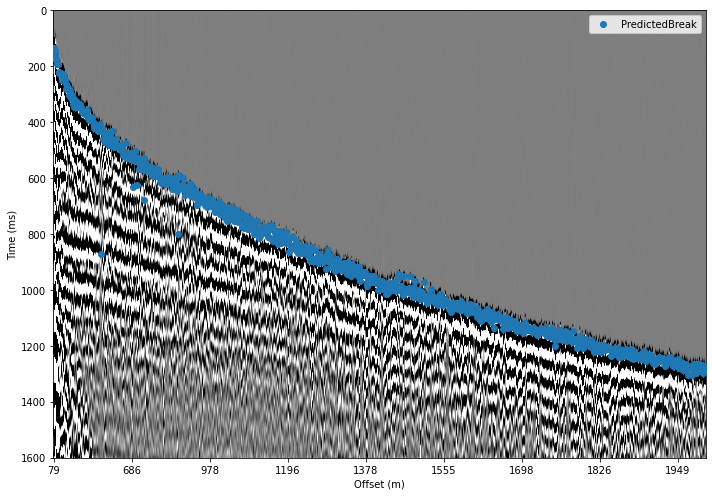

In [54]:
g = survey.sample_gather()
g.sort(by='offset')
g.plot(event_headers=['PredictedBreak'])

## MetricMap

In [221]:
%matplotlib widget

In [77]:
header_cols = ['TraceNumber', 'FieldRecord', 'offset', 'TRACE_SEQUENCE_FILE',
               "INLINE_3D", "CROSSLINE_3D", "offset", "SourceX", "SourceY", "GroupX", "GroupY", "CDP_X", "CDP_Y"]
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=header_cols, name='full')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [78]:
survey.load_first_breaks(path=save_breaks_path,  trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='FirsBreak1D', inplace=True)

survey.load_first_breaks(path=breaks_2d_path,  trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='FirsBreak2D', inplace=True)

In [95]:
metrics_pipeline_template = (Pipeline()
                             .init_variable('accumulator_1d')
                             .init_variable('accumulator_2d')
                             
                             .load(src='full')
                             
                             .calculate_refractor_velocity(src='full', n_refractors=2, first_breaks_col='FirsBreak1D', dst='refractor_velocity_1d') 
                             .calculate_refractor_velocity(src='full', n_refractors=2, first_breaks_col='FirsBreak2D', dst='refractor_velocity_2d')
                             
                             .calculate_metric(FirstBreaksOutliers, gather="full", 
                                               refractor_velocity=B('refractor_velocity_1d') ,
                                               first_breaks_col='FirsBreak1D', save_to=V("accumulator_1d", mode="a"))
                             .calculate_metric(FirstBreaksOutliers, gather="full", 
                                               refractor_velocity=B('refractor_velocity_2d') ,
                                               first_breaks_col='FirsBreak2D', save_to=V("accumulator_2d", mode="a"))
                            )
                            

In [80]:
map_dataset = SeismicDataset(survey)

In [99]:
map_dataset.reindex('FieldRecord', inplace=True)

In [69]:
len(map_dataset)

71482

In [106]:
metrics_pipeline = metrics_pipeline_template << map_dataset

metrics_pipeline.run(batch_size=64, n_epochs=1, bar='n')

  0%|                                                                                                         …

In [111]:
%matplotlib widget

In [115]:
mmap_1d = metrics_pipeline.v('accumulator_1d').construct_map()

In [116]:
mmap_1d.plot(interactive=True)

In [117]:
mmap_2d = metrics_pipeline.v('accumulator_2d').construct_map()

In [118]:
mmap_2d.plot(interactive=True)